In [1]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *

from collections import Counter
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb

sns.set_style('ticks')

In [2]:
input_path = '../Data'

feature_file = 'Mordred_features_in-house.csv'
features_file_2 =  'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

# Read all copies, before and after correction; before was also downloaded from Dropbox.
mixture_file = 'Mixure_Definitions_Training_set.csv' 

training_task_file = 'TrainingData_mixturedist.csv'

# Dragon features
features = pd.read_csv(os.path.join(input_path, feature_file), index_col= 0)
features_2 = np.load(os.path.join(input_path, features_file_2))

features_CIDs = np.load(os.path.join(input_path, CID_file))


# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))


Our filtering: get rid of all columns that contains all NaN, and columns that contains the same value.

In [3]:
Mordred_des = features.columns.tolist()
print('Num of filtered Mordred descriptors: ', len(Mordred_des))

Num of filtered Mordred descriptors:  1282


In [4]:
features.head()

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
176,1,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,1.931852,0.482963,...,6.188264,24.179697,60.021129,7.502641,9,0,12.0,9.0,3.111111,1.000000
177,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,1.707107,0.569036,...,4.174387,17.310771,44.026215,6.289459,4,0,6.0,4.0,2.250000,1.000000
179,0,0,6.000000,2.000000,4.000000,6.000000,1.000000,2.610845,2.309401,0.384900,...,7.626083,30.698690,88.052429,6.289459,29,4,22.0,21.0,4.222222,1.444444
180,0,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,1.931852,0.482963,...,6.188264,24.179697,58.041865,5.804186,9,0,12.0,9.0,3.111111,1.000000
240,0,0,10.424292,2.135779,4.271558,10.424292,1.303037,2.969338,2.718002,0.339750,...,8.298291,35.247635,106.041865,7.574419,64,7,34.0,36.0,2.611111,2.000000


Not all features are positive, we are going to just normalize first, and try average and log exp.

In [5]:
negative_counts= (features < 0).sum()
columns_with_negatives = negative_counts[negative_counts > 0]
columns_with_negatives

VE3_A            10
ATSC1c          156
ATSC2c           85
ATSC3c          100
ATSC4c           89
               ... 
FilterItLogS    153
VSA_EState4       1
VSA_EState5      48
VSA_EState7       6
SLogP             5
Length: 334, dtype: int64

In [6]:
scaler = StandardScaler(with_mean=True, with_std=True)

# standardize Mordred
features = scaler.fit_transform(features)
# log standardize deepnose
epsilon = 1e-8 
features_2 = scaler.fit_transform(np.log(features_2 + epsilon))

In [7]:
# Convert DataFrame to a numpy array
features_array = features

# Create an imputer object with mean strategy, can change later!!!
imputer = SimpleImputer(strategy='mean')
# Impute missing values
imputed_features = imputer.fit_transform(features_array)


# imputer = SimpleImputer(strategy='constant', fill_value= -5)
# imputed_features = imputer.fit_transform(features_array)


In [8]:
imputed_features.shape

(162, 1282)

In [9]:
# Double check the number of unique non-NaN values in each feature column
num_unique_values = np.count_nonzero(~np.isnan(features), axis=0)

# Print if the number of unique non-NaN values for each feature
for i, count in enumerate(num_unique_values):
    if count == 0:
        print(f"Feature {i}: {count} unique non-NaN values")

In [10]:
# Map CID to 96 dim features:
CID2features_mordred =  {CID: imputed_features[i] for i, CID in enumerate(features_CIDs)}
CID2features_deepnose=  {CID: features_2[i] for i, CID in enumerate(features_CIDs)}

In [11]:
X_m, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features_mordred, method = 'avg')
X_d, _, _, _ = format_Xy(training_set,  mixtures_IDs, CID2features_deepnose, method = 'avg')

In [12]:
# Convert the input pairs to a suitable format for training
X_pairs_m = np.array([(np.concatenate((x1, x2))) for x1, x2 in X_m])
X_pairs_d = np.array([(np.concatenate((x1, x2))) for x1, x2 in X_d])

y_true = np.array(y)

 <span style="color:orange;">NOTE: Not sure yet how to get the distance similarity etc with NaN values; we have just imputated with mean </span>

In [13]:
distances_m = [get_euclidean_distance(m[0], m[1]) for m in X_m]
similarities_m = [get_cosine_similarity(m[0], m[1]) for m in X_m]
angles_m = [get_cosine_angle(m[0], m[1]) for m in X_m] 

distances_d = [get_euclidean_distance(m[0], m[1]) for m in X_d]
similarities_d = [get_cosine_similarity(m[0], m[1]) for m in X_d]
angles_d = [get_cosine_angle(m[0], m[1]) for m in X_d] 

In [14]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [15]:
training_set['Sum num monos'] = np.array(num_mixtures).sum(axis = 1)
training_set['Shared'] = shared_monos
training_set['Diff'] = diff_monos
training_set['Num mixture1'] = np.array(num_mixtures)[:, 0]
training_set['Num mixture2'] = np.array(num_mixtures)[:, 1]

In [16]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [17]:
### add all information above
X_features = np.hstack( (X_pairs_d, X_pairs_m,
                        np.array(distances_m).reshape(500, 1), 
                        np.array(similarities_m).reshape(500, 1), 
                        np.array(angles_m).reshape(500, 1), 
                        np.array(distances_d).reshape(500, 1), 
                        np.array(similarities_d).reshape(500, 1), 
                        np.array(angles_d).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures).reshape(500,2), 
                        data_arr))

In [18]:
feature_names = [f'Dn_dim{i}_1' for i in range(96)] +  [f'Dn_dim{i}_2' for i in range(96)] +  \
                    [f'{m}_1' for m in Mordred_des] + \
                    [f'{m}_2' for m in Mordred_des] + \
                    ['dist_Md', 'sim_Md', 'angle_Md', 'dist_Dn', 'sim_Dn', 'angle_Dn'] + \
                    ['shared_mono', 
                     'diff_mono', 
                     'num_mix1',
                     'num_mix2',
                     'snitz 1',
                     'snitz 2', 
                     'ravia', 
                     'bushdid'] 

### First training:

In [19]:
n_folds = 10
seed = 314159

In [20]:
rf_pred_list = []
xgb_pred_list = []
kf_rf_importances = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    # Get the feature importances
    importances = rf.feature_importances_
    kf_rf_importances.append(importances)
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [21]:
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,Sum num monos,Shared,Diff,Num mixture1,Num mixture2,rf_pred,xgb_pred,y_true
150,Snitz 1,1,2,0.604167,20,0,10,10,10,0.540579,0.590123,0.604167
300,Snitz 1,1,3,0.651042,11,0,10,10,1,0.629684,0.631518,0.651042
0,Snitz 1,1,5,0.505208,40,0,10,10,30,0.506728,0.501953,0.505208
1,Snitz 1,1,6,0.411458,50,0,10,10,40,0.527859,0.501155,0.411458
50,Snitz 1,1,7,0.562500,14,0,10,10,4,0.540250,0.508182,0.562500


In [22]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.622
Random Forest - RMSE: 0.123

XGBoost - R: 0.543
XGBoost - RMSE: 0.134


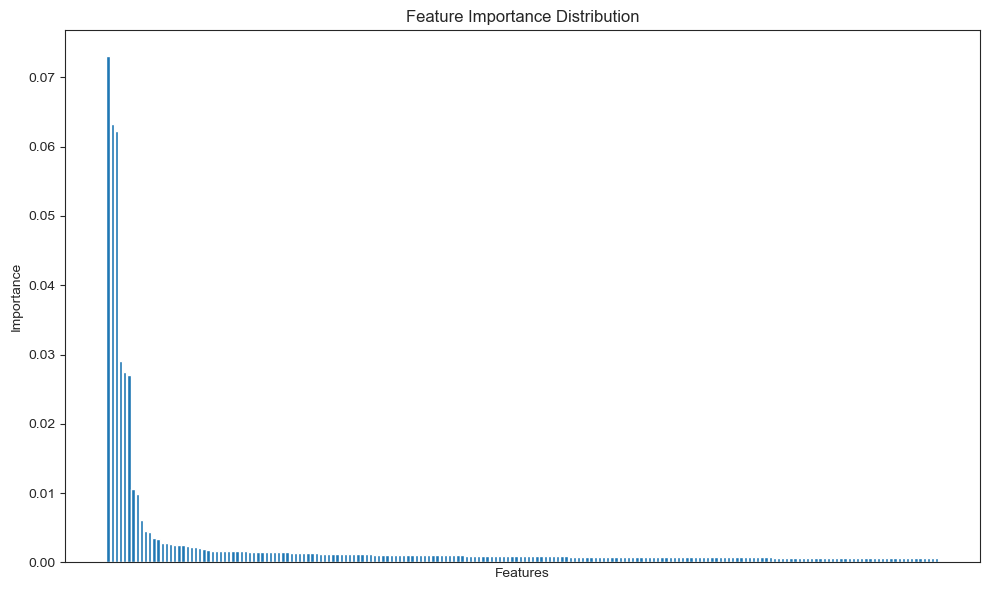

In [23]:

# Calculate the mean feature importances across all folds
mean_importances = np.mean(kf_rf_importances, axis=0)

# Sort the features by their mean importance
sorted_indices = np.argsort(mean_importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = mean_importances[sorted_indices]

# Plot the feature importance distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features))[:200], sorted_importances[:200])
# plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.xticks([])

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Distribution')
plt.tight_layout()
plt.show()

#### Observations:

1. RF although in this example has a better score, tends to predict a safe value

2. prediction are correlated for the two methods, off ones are predicted off in the same way..

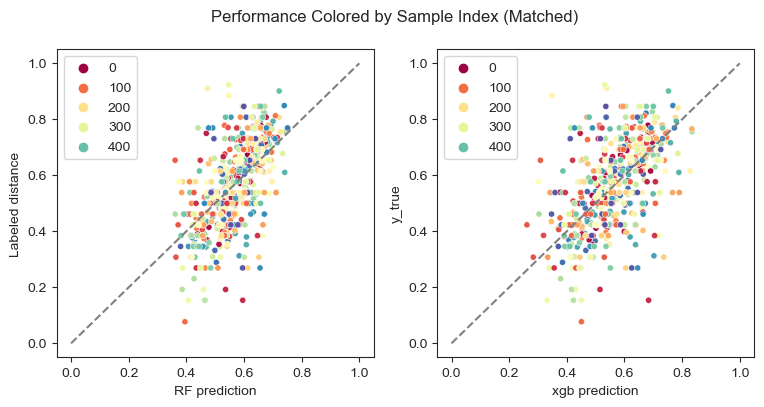

In [24]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = training_set.index, ax = ax[0], s = 20, palette= 'Spectral')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = training_set.index, ax = ax[1], s = 20, palette= 'Spectral')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Sample Index (Matched)')

plt.show()

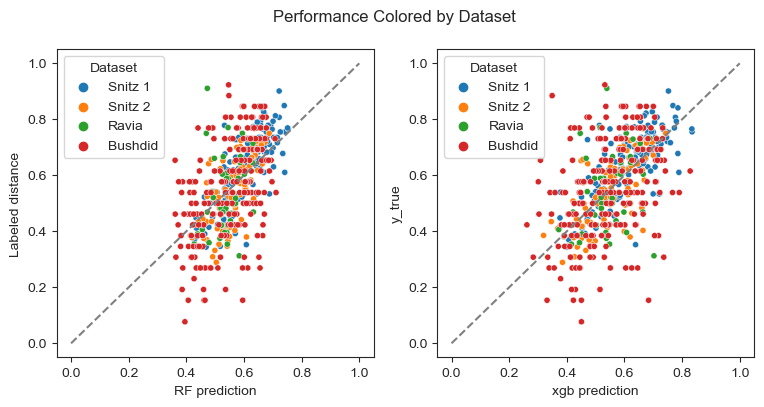

In [25]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Dataset', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Dataset', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Dataset')
plt.show()

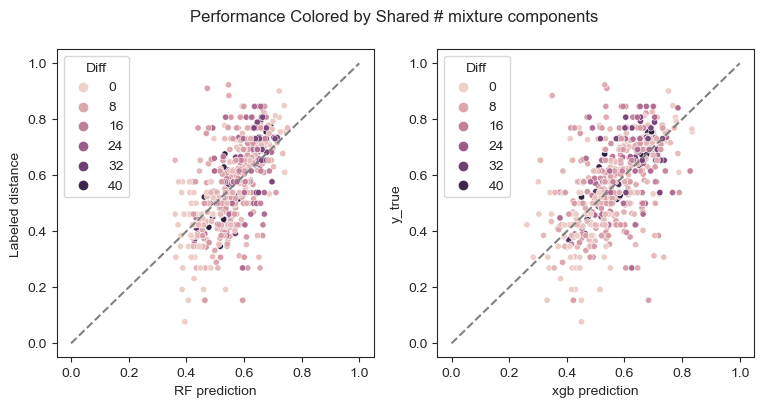

In [26]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Diff', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Diff', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Shared # mixture components')

plt.show()

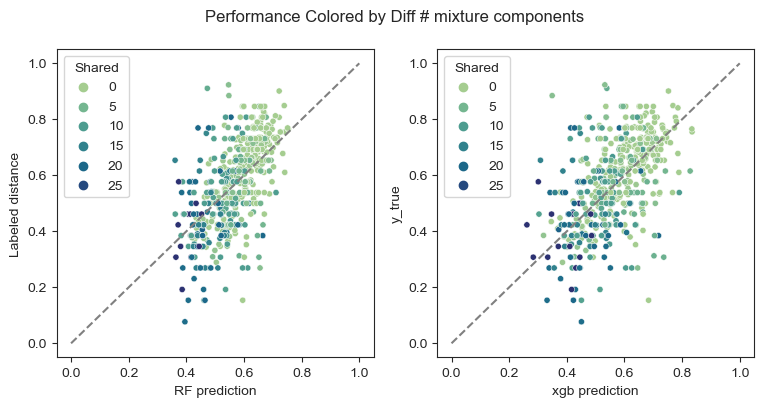

In [27]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Shared', ax = ax[0], s = 20, palette= 'crest')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Shared', ax = ax[1], s = 20, palette= 'crest')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Diff # mixture components')

plt.show()

In [28]:
training_set.groupby('Dataset')['rf_pred', 'y_true'].apply(
    lambda x: abs(x['rf_pred'] - x['y_true']).mean())

/var/folders/63/lv4_06n90jx2p5v2t58ssgwr0000gp/T/ipykernel_3085/3348153056.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  training_set.groupby('Dataset')['rf_pred', 'y_true'].apply(


Dataset
Bushdid    0.118434
Ravia      0.098279
Snitz 1    0.066827
Snitz 2    0.077048
dtype: float64

In [29]:
training_set.groupby('Dataset')['xgb_pred', 'y_true'].apply(
    lambda x: abs(x['xgb_pred'] - x['y_true']).mean())

/var/folders/63/lv4_06n90jx2p5v2t58ssgwr0000gp/T/ipykernel_3085/2246081906.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  training_set.groupby('Dataset')['xgb_pred', 'y_true'].apply(


Dataset
Bushdid    0.131278
Ravia      0.104498
Snitz 1    0.065293
Snitz 2    0.072510
dtype: float64